As our team used google colab for much of this there are some code cells that account for runs on google colab, however much of the visualization can only be done locally so these cells will be commented out when submitted

In [57]:
#for google colab
#from google.colab import drive
#drive.mount('/content/drive')

We perform all relevant imports and read in our primary dataset

In [58]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import folium
import geopandas as gpd

#make sure the csv is in your top level drive directory, if you try and put it in a subfolder then that filepath becomes invalid for the others
data = pd.read_csv('Housing.csv')
#data = pd.read_csv('/content/drive/My Drive/Housing.csv')
#data = pd.read_csv('/content/drive/My Drive/cmsc320-finalproject/Housing.csv')

Perform data cleaning and encoding of data types in incorrect/unusable formats

We also perform feature creation, it may be useful to have additional data such as the total number of rooms in a house and the price per square footage

In [59]:
data = pd.read_csv('Housing.csv')
#parse


#handling NaNs
print(data.isnull().sum())

data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms'].median()) # Filling missing values
data['bathrooms'] = data['bathrooms'].fillna(data['bathrooms'].median())

data.dropna(subset=['price'], inplace=True) # Dropping rows where the 'price' is missing

data['yr_renovated'] = data['yr_renovated'].fillna(0) # Filling 'yr_renovated' with 0 where NaNs may imply no renovation


#string converts
data['date'] = pd.to_datetime(data['date'])
data['id'] = data['id'].astype(str)


#encoding
data['house_age'] = data['date'].dt.year - data['yr_built']
#should make years since renovation equal years since it was built if 0
#data['years_since_renovation'] = data.apply(lambda row: row['date'].year - row['yr_renovated'] if row['yr_renovated'] != 0 else 0, axis=1)
data['years_since_renovation'] = data.apply(
    lambda row: row['date'].year - row['yr_renovated'] if row['yr_renovated'] != 0 else row['date'].year - row['yr_built'],
    axis=1
)
#Mihir new cols
data['num_rooms'] = data['bedrooms'] + data['bathrooms']
data['living percentage'] = (data['sqft_living'])/(data['sqft_lot'])
data['price_per_sqft_living'] = data['price']/data['sqft_living']
data['price_per_sqft_lot'] = data['price']/data['sqft_lot']

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [60]:
# organize (sort by date)
data.sort_values(by='date', inplace=True)
data.reset_index(drop=True, inplace=True)

Data exploration

In [61]:
#general testing
data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,house_age,years_since_renovation,num_rooms,living percentage,price_per_sqft_living,price_per_sqft_lot
0,5561000190,2014-05-02,437500.0,3,2.25,1970,35100,2.0,0,0,...,47.4635,-121.991,2340,35100,37,37,5.25,0.056125,222.081218,12.464387
1,472000620,2014-05-02,790000.0,3,2.50,2600,4750,1.0,0,0,...,47.6833,-122.400,2380,4750,63,63,5.50,0.547368,303.846154,166.315789
2,1024069009,2014-05-02,675000.0,5,2.50,2820,67518,2.0,0,0,...,47.5794,-122.025,2820,48351,35,35,7.50,0.041767,239.361702,9.997334
3,7853361370,2014-05-02,555000.0,4,2.50,3310,6500,2.0,0,0,...,47.5150,-121.870,2380,5000,2,2,6.50,0.509231,167.673716,85.384615
4,5056500260,2014-05-02,440000.0,4,2.25,2160,8119,1.0,0,0,...,47.5443,-122.177,1850,9000,48,48,6.25,0.266043,203.703704,54.193866
5,3438501320,2014-05-02,295000.0,2,2.50,1630,1368,2.0,0,0,...,47.5489,-122.363,1590,2306,5,5,4.50,1.191520,180.981595,215.643275
6,1737320120,2014-05-02,470000.0,5,2.50,2210,9655,1.0,0,0,...,47.7698,-122.222,2080,8633,38,38,7.50,0.228897,212.669683,48.679441
7,7197300105,2014-05-02,550000.0,4,2.50,1940,10500,1.0,0,0,...,47.6830,-122.114,2200,10500,38,38,6.50,0.184762,283.505155,52.380952
8,1999700045,2014-05-02,313000.0,3,1.50,1340,7912,1.5,0,0,...,47.7658,-122.339,1480,7940,59,59,4.50,0.169363,233.582090,39.560162
9,1962200037,2014-05-02,626000.0,3,2.25,1750,1572,2.5,0,0,...,47.6498,-122.321,2410,3050,9,9,5.25,1.113232,357.714286,398.218830


Mihir's Section

As we are looking to explore this data set it may be a good idea to get an idea of how all the variables are interrelated

In [62]:
#Mihir - Covariance matrix of all features
CovMatrix = data.cov()

#However correlation matrix will be more useful as it scales everything using standard deviations to between -1 to 1, makes it easier to compare between factors
CorrMatrix = data.corr(method = 'pearson')


In [63]:
#prints much better if you stick it in its own cell
data.cov()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,house_age,years_since_renovation,num_rooms,living percentage,price_per_sqft_living,price_per_sqft_lot
id,8.274654e+18,1.566785e+23,-1.770230e+13,3.316999e+06,1.142695e+07,-3.238863e+10,-1.574064e+13,2.877320e+07,-6.772400e+05,2.555269e+07,...,-7.539282e+05,8.425348e+06,-5.722532e+09,-1.090153e+13,-1.792808e+09,-1.434415e+09,1.474395e+07,6.806534e+07,-1.749445e+09,1.618107e+10
date,1.566785e+23,9.540109e+31,-1.562305e+19,-1.525486e+14,-2.588457e+14,-3.100206e+17,2.553979e+18,-1.186211e+14,1.145477e+12,-1.347551e+13,...,-4.446697e+13,-9.655969e+12,-2.109778e+17,6.842317e+17,3.999961e+15,7.098913e+15,-4.113943e+14,-1.267093e+13,4.081743e+16,7.885853e+15
price,-1.770230e+13,-1.562305e+19,1.347821e+11,1.053004e+05,1.484810e+05,2.367150e+08,1.363432e+09,5.090779e+04,8.460640e+03,1.117729e+05,...,1.561740e+04,1.118099e+03,1.472961e+08,8.264560e+08,-5.818276e+05,-1.117816e+06,2.537814e+05,1.213879e+04,2.241334e+07,1.063007e+07
bedrooms,3.316999e+06,-1.525486e+14,1.053004e+05,8.650956e-01,3.695787e-01,4.926377e+02,1.221762e+03,8.812733e-02,-5.293190e-04,5.669500e-02,...,-1.148704e-03,1.696024e-02,2.496817e+02,7.429740e+02,-4.217009e+00,-4.439367e+00,1.234674e+00,6.658814e-03,-2.109089e+01,-5.451275e+00
bathrooms,1.142695e+07,-2.588457e+14,1.484810e+05,3.695787e-01,5.931513e-01,5.338120e+02,2.798944e+03,2.082114e-01,4.247388e-03,1.108004e-01,...,2.622344e-03,2.419130e-02,3.001611e+02,1.833182e+03,-1.145691e+01,-1.192709e+01,9.627300e-01,5.922581e-02,-7.749677e+00,1.464115e+01
sqft_living,-3.238863e+10,-3.100206e+17,2.367150e+08,4.926377e+02,5.338120e+02,8.435337e+05,6.574684e+06,1.755404e+02,8.249461e+00,2.003143e+02,...,6.685035e+00,3.107108e+01,4.761601e+05,4.596302e+06,-8.592709e+03,-9.107057e+03,1.026450e+03,1.904793e+01,-9.331851e+03,1.947152e+03
sqft_lot,-1.574064e+13,2.553979e+18,1.363432e+09,1.221762e+03,2.798944e+03,6.574684e+06,1.715659e+09,-1.163286e+02,7.741867e+01,2.371393e+03,...,-4.917661e+02,1.338837e+03,4.105319e+06,8.126540e+08,-6.447493e+04,-6.302673e+04,4.020705e+03,-2.811031e+03,-1.541897e+05,-8.039670e+05
floors,2.877320e+07,-1.186211e+14,5.090779e+04,8.812733e-02,2.082114e-01,1.755404e+02,-1.163286e+02,2.915880e-01,1.107146e-03,1.218394e-02,...,3.712271e-03,9.537583e-03,1.035866e+02,-1.661524e+02,-7.766885e+00,-7.867447e+00,2.963387e-01,8.078183e-02,2.280253e-01,2.428315e+01
waterfront,-6.772400e+05,1.145477e+12,8.460640e+03,-5.293190e-04,4.247388e-03,8.249461e+00,7.741867e+01,1.107146e-03,7.485226e-03,2.664300e-02,...,-1.711161e-04,-5.106370e-04,5.127103e+00,7.252979e+01,6.631481e-02,1.169693e-03,3.718069e-03,-6.941712e-04,1.839817e+00,2.490478e-01
view,2.555269e+07,-1.347551e+13,1.117729e+05,5.669500e-02,1.108004e-01,2.003143e+02,2.371393e+03,1.218394e-02,2.664300e-02,5.872426e-01,...,6.537452e-04,-8.460837e-03,1.472943e+02,1.518526e+03,1.203386e+00,4.036811e-01,1.674954e-01,-2.690266e-04,1.863367e+01,5.681183e+00


However the correlation matrix will be more useful as it scales everything using standard deviations to between -1 to 1, makes it easier to compare between factors

In [64]:
data.corr(method = 'pearson')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,house_age,years_since_renovation,num_rooms,living percentage,price_per_sqft_living,price_per_sqft_lot
id,1.000000,0.005576,-0.016762,0.001240,0.005158,-0.012259,-0.132109,0.018524,-0.002721,0.011592,...,-0.001891,0.020798,-0.002903,-0.138798,-0.021216,-0.017306,0.003458,0.088105,-0.005526,0.059807
date,0.005576,1.000000,-0.004357,-0.016792,-0.034410,-0.034559,0.006313,-0.022491,0.001356,-0.001800,...,-0.032856,-0.007020,-0.031515,0.002566,0.013941,0.025224,-0.028414,-0.004830,0.037970,0.008584
price,-0.016762,-0.004357,1.000000,0.308377,0.525136,0.702035,0.089661,0.256793,0.266370,0.397294,...,0.307003,0.021626,0.585378,0.082447,-0.053950,-0.105671,0.466325,0.123115,0.554701,0.307848
bedrooms,0.001240,-0.016792,0.308377,1.000000,0.515932,0.576693,0.031713,0.175466,-0.006578,0.079543,...,-0.008913,0.129482,0.391666,0.029256,-0.154343,-0.165650,0.895500,0.026657,-0.206030,-0.062314
bathrooms,0.005158,-0.034410,0.525136,0.515932,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,...,0.024573,0.223042,0.568634,0.087175,-0.506407,-0.537469,0.843270,0.286338,-0.091426,0.202120
sqft_living,-0.012259,-0.034559,0.702035,0.576693,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,...,0.052529,0.240223,0.756420,0.183286,-0.318488,-0.344135,0.753931,0.077223,-0.092318,0.022541
sqft_lot,-0.132109,0.006313,0.089661,0.031713,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,...,-0.085683,0.229521,0.144608,0.718557,-0.052990,-0.052809,0.065483,-0.252697,-0.033823,-0.206367
floors,0.018524,-0.022491,0.256793,0.175466,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,...,0.049614,0.125419,0.279885,-0.011269,-0.489640,-0.505651,0.370210,0.557030,0.003837,0.478120
waterfront,-0.002721,0.001356,0.266370,-0.006578,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,...,-0.014274,-0.041910,0.086463,0.030703,0.026093,0.000469,0.028991,-0.029875,0.193215,0.030605
view,0.011592,-0.001800,0.397294,0.079543,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,...,0.006157,-0.078400,0.280439,0.072575,0.053458,0.018282,0.147448,-0.001307,0.220932,0.078822


As our ultimate goal is to predict the price of a house based on its feature, the most relevant column of this matrix is of the price

In [65]:
#correlations of price with all other current variables
print(CorrMatrix['price'])

id                       -0.016762
date                     -0.004357
price                     1.000000
bedrooms                  0.308377
bathrooms                 0.525136
sqft_living               0.702035
sqft_lot                  0.089661
floors                    0.256793
waterfront                0.266370
view                      0.397294
condition                 0.036361
grade                     0.667434
sqft_above                0.605567
sqft_basement             0.323816
yr_built                  0.054011
yr_renovated              0.126434
zipcode                  -0.053201
lat                       0.307003
long                      0.021626
sqft_living15             0.585378
sqft_lot15                0.082447
house_age                -0.053950
years_since_renovation   -0.105671
num_rooms                 0.466325
living percentage         0.123115
price_per_sqft_living     0.554701
price_per_sqft_lot        0.307848
Name: price, dtype: float64


As we can see the grading system that has been used by the realtors is quite good and is fairly correlated with price, another factor that is hugely correlated with price is square footage, which is why it may be better to explore price per square footage to gain insight into what nontrivial qualities affect the price of a house

In [66]:
print(CorrMatrix['price_per_sqft_living'])

id                       -0.005526
date                      0.037970
price                     0.554701
bedrooms                 -0.206030
bathrooms                -0.091426
sqft_living              -0.092318
sqft_lot                 -0.033823
floors                    0.003837
waterfront                0.193215
view                      0.220932
condition                 0.102344
grade                     0.122757
sqft_above               -0.088620
sqft_basement            -0.025764
yr_built                 -0.289869
yr_renovated              0.105482
zipcode                   0.172637
lat                       0.472049
long                     -0.236033
sqft_living15             0.038560
sqft_lot15               -0.057516
house_age                 0.290573
years_since_renovation    0.249878
num_rooms                -0.176774
living percentage         0.116634
price_per_sqft_living     1.000000
price_per_sqft_lot        0.450463
Name: price_per_sqft_living, dtype: float64


We can also find all other correlations that may be of interest by printing those above a certain R^2 value

In [67]:
#finding all other correlations that may be of interest
correlationThreshold = 0.3
checkedList = []

for row in CorrMatrix.index:
  for col in CorrMatrix.columns:
    if (not row in checkedList) and (not col in checkedList) and (row != col) and (CorrMatrix[row][col] > correlationThreshold or CorrMatrix[row][col] < -correlationThreshold):
      print(row, col, CorrMatrix[row][col])
  checkedList.append(row)

price bedrooms 0.3083769180156153
price bathrooms 0.5251363218554719
price sqft_living 0.7020346040056666
price view 0.39729352797680806
price grade 0.6674342691668146
price sqft_above 0.6055670405615354
price sqft_basement 0.3238155679576574
price lat 0.3070033728790943
price sqft_living15 0.5853783781780082
price num_rooms 0.4663250127585262
price price_per_sqft_living 0.5547008682090738
price price_per_sqft_lot 0.30784846349389644
bedrooms bathrooms 0.5159316152210395
bedrooms sqft_living 0.57669257587632
bedrooms grade 0.3569778987944419
bedrooms sqft_above 0.47761446504670363
bedrooms sqft_basement 0.30311202501453155
bedrooms sqft_living15 0.39166621103010474
bedrooms num_rooms 0.8954995511941201
bathrooms sqft_living 0.7546652789673763
bathrooms floors 0.5006531725878747
bathrooms grade 0.664982533878076
bathrooms sqft_above 0.6853424758761565
bathrooms yr_built 0.5060194382852586
bathrooms sqft_living15 0.5686342895782276
bathrooms house_age -0.5064069441397088
bathrooms years_

This creates a heatmap of all the houses so we can visualize all areas of interest that will be covered by our dataset

In [68]:
houses_map = folium.Map(location=[data['lat'].mean(), data['long'].mean()], zoom_start=10)

for _, row in data.iterrows():
    folium.Marker(
        [row['lat'], row['long']]
    ).add_to(houses_map)

houses_map.save('AllHouseLocations.html')

from folium.plugins import HeatMap
houses_heatmap = folium.Map(location=[data['lat'].mean(), data['long'].mean()], zoom_start=10)
heat_data = data[['lat', 'long']].values.tolist()
HeatMap(heat_data).add_to(houses_heatmap)
houses_heatmap.save('AllHouseLocationsHeatmap.html')

houses_heatmap

As we can see we cover most of the Seattle area, but not Seattle itself

### Susie's Stuff

#### Summary Statistics Calculation for Boolean/Categorical Data
First, we calculate summary statistics for categorical features such as 'waterfront', 'view', 'condition', 'grade', and 'floors'. This helps us understand the distribution and typical values of these categorical variables.

In [69]:
# Analysis on boolean/categorical data (waterfront, view, condition, grade, floors)
def calculate_summary_statistics(data, column_name):
    count = data[column_name].count()  # Count non-null entries
    mean = data[column_name].mean()  # Mean
    std = data[column_name].std()  # Standard deviation
    min_val = data[column_name].min()  # Minimum value
    q25 = data[column_name].quantile(0.25)  # 25th percentile
    median = data[column_name].median()  # Median
    q75 = data[column_name].quantile(0.75)  # 75th percentile
    max_val = data[column_name].max()  # Maximum value

    return {
        "Count": count,
        "Mean": mean,
        "Standard Deviation": std,
        "Min": min_val,
        "25th Percentile": q25,
        "50th Percentile (Median)": median,
        "75th Percentile": q75,
        "Max": max_val
    }

columns_to_analyze = ['waterfront', 'view', 'condition', 'grade', 'floors']

# Calculating and displaying summary statistics for each column
summary_statistics = {}
for column in columns_to_analyze:
    summary_statistics[column] = calculate_summary_statistics(data, column)

summary_statistics

{'waterfront': {'Count': 21613,
  'Mean': 0.007541757275713691,
  'Standard Deviation': 0.08651719772790183,
  'Min': 0,
  '25th Percentile': 0.0,
  '50th Percentile (Median)': 0.0,
  '75th Percentile': 0.0,
  'Max': 1},
 'view': {'Count': 21613,
  'Mean': 0.23430342849211122,
  'Standard Deviation': 0.7663175692736391,
  'Min': 0,
  '25th Percentile': 0.0,
  '50th Percentile (Median)': 0.0,
  '75th Percentile': 0.0,
  'Max': 4},
 'condition': {'Count': 21613,
  'Mean': 3.4094295100171195,
  'Standard Deviation': 0.6507430463662562,
  'Min': 1,
  '25th Percentile': 3.0,
  '50th Percentile (Median)': 3.0,
  '75th Percentile': 4.0,
  'Max': 5},
 'grade': {'Count': 21613,
  'Mean': 7.656873178179799,
  'Standard Deviation': 1.1754587569743047,
  'Min': 1,
  '25th Percentile': 7.0,
  '50th Percentile (Median)': 7.0,
  '75th Percentile': 8.0,
  'Max': 13},
 'floors': {'Count': 21613,
  'Mean': 1.4943089807060566,
  'Standard Deviation': 0.5399888951423845,
  'Min': 1.0,
  '25th Percentile':

#### Chi-Square Test for Independence Between Categorical Variables
Next, we perform Chi-square tests to examine the independence between pairs of categorical variables. This statistical test helps us understand if there are significant associations between different property characteristics.

In [70]:
# Chi-Square Test to waterfront and view, waterfront and condition, view and condition, condition and grade, grade and floors

from scipy.stats import chi2_contingency

def chi_square_test(data, var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Pairs of variables to test
variable_pairs = [
    ('waterfront', 'view'),
    ('waterfront', 'condition'),
    ('view', 'condition'),
    ('condition', 'grade'),
    ('grade', 'floors')
]

# Performing Chi-Square Tests
chi_square_results = {}
for var1, var2 in variable_pairs:
    chi2, p, dof, expected = chi_square_test(data, var1, var2)
    chi_square_results[(var1, var2)] = {'chi2': chi2, 'p-value': p, 'dof': dof, 'expected': expected}

chi_square_results


# Interpretation:
# Waterfront vs. View: The p-value is 0.0, which is less than 0.05, indicating that there is a significant association between the waterfront status and the view rating.
# Waterfront vs. Condition: The p-value is 0.039, which is less than 0.05, indicating that there is a significant association between the waterfront status and the condition of the house.
# View vs. Condition: The p-value is extremely low (1.82e-08), indicating a significant association between the view rating and the condition of the house.
# Condition vs. Grade: The p-value is 0.0, which is less than 0.05, indicating a significant association between the condition of the house and its grade.
# Grade vs. Floors: The p-value is 0.0, which is less than 0.05, indicating a significant association between the grade of the house and the number of floors.

{('waterfront', 'view'): {'chi2': 7572.5563318397735,
  'p-value': 0.0,
  'dof': 4,
  'expected': array([[1.93420187e+04, 3.29496137e+02, 9.55737288e+02, 5.06153704e+02,
          3.16594179e+02],
         [1.46981308e+02, 2.50386342e+00, 7.26271226e+00, 3.84629621e+00,
          2.40582057e+00]])},
 ('waterfront', 'condition'): {'chi2': 10.074729585287205,
  'p-value': 0.03918751144589182,
  'dof': 4,
  'expected': array([[2.97737473e+01, 1.70702818e+02, 1.39251816e+04, 5.63617036e+03,
          1.68817147e+03],
         [2.26252718e-01, 1.29718225e+00, 1.05818396e+02, 4.28296396e+01,
          1.28285291e+01]])},
 ('view', 'condition'): {'chi2': 68.50224408217254,
  'p-value': 1.822893843270391e-08,
  'dof': 16,
  'expected': array([[2.70517744e+01, 1.55096840e+02, 1.26521149e+04, 5.12090089e+03,
          1.53383561e+03],
         [4.60833757e-01, 2.64211354e+00, 2.15531948e+02, 8.72358303e+01,
          2.61292740e+01],
         [1.33669551e+00, 7.66372091e+00, 6.25172489e+02, 2.53

#### T-Test for Difference in House Prices: With vs. Without Basement
We conduct a t-test to determine if there is a significant difference in the prices of houses with basements versus those without.

T-statistic: 26.93602313477148, P-value: 3.266907478647668e-157


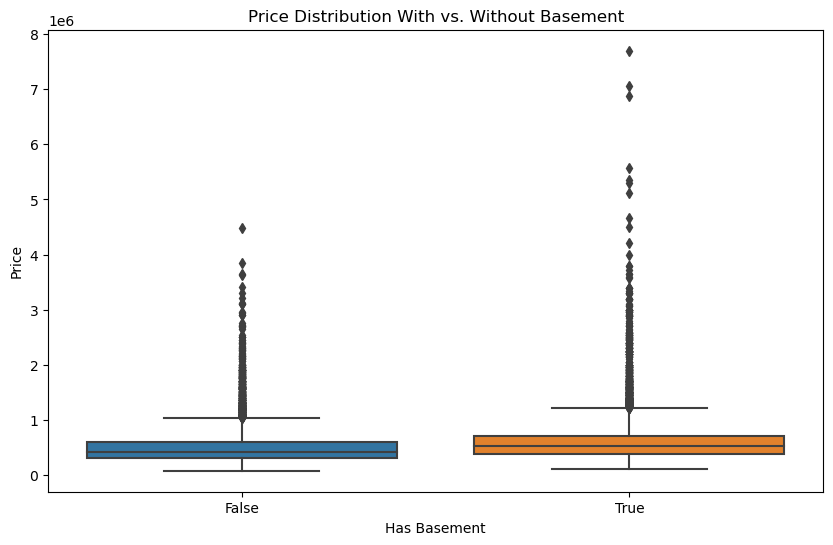

In [71]:
# Susie - Test if the mean price of houses with a basement is significantly different from those without a basement
from scipy.stats import ttest_ind

# Split data based on houses with/without basement
with_basement = data[data['sqft_basement'] > 0]
without_basement = data[data['sqft_basement'] == 0]

# Performing a t-test
t_stat, p_val = ttest_ind(with_basement['price'], without_basement['price'])

print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='sqft_basement', y='price', data=data.assign(sqft_basement=data['sqft_basement']>0))
plt.title('Price Distribution With vs. Without Basement')
plt.xlabel('Has Basement')
plt.ylabel('Price')
plt.show()


### Abhi's Stuff + Mihir folium

Most expensive vs. least expensive zipcodes

In [72]:

zipcode_df = data.groupby('zipcode').agg(
    avg_price=('price', 'mean'),
    avg_price_per_sqft=('price_per_sqft_living', 'mean'),
    avg_sqft_living = ('sqft_living', 'mean'),
    avg_sqft_lot = ('sqft_lot', 'mean'),
    avg_age = ('house_age','mean'),
    total_houses=('zipcode', 'size')
).reset_index()
zipcode_df

,zipcode,avg_price,avg_price_per_sqft,avg_sqft_living,avg_sqft_lot,avg_age,total_houses
0,98001,2.808047e+05,151.387938,1900.856354,14937.450276,33.643646,362
1,98002,2.342840e+05,151.174091,1627.743719,7517.633166,46.562814,199
2,98003,2.941113e+05,157.113414,1928.882143,10603.096429,37.457143,280
3,98004,1.355927e+06,475.435611,2909.022082,13104.220820,42.867508,317
4,98005,8.101649e+05,314.929231,2656.803571,19928.785714,44.553571,168
...,...,...,...,...,...,...,...
65,98177,6.761854e+05,292.918745,2323.333333,11904.403922,53.447059,255
66,98178,3.106486e+05,189.202933,1729.351145,8309.122137,59.061069,262
67,98188,2.890783e+05,169.007306,1802.772059,10126.080882,48.882353,136
68,98198,3.028789e+05,178.428610,1745.360714,10525.978571,47.614286,280


Average house age per zipcode

In [73]:
zipcode_df["house_age"] = data.groupby("zipcode").apply(lambda x: x["house_age"].mean()).sort_values(ascending=False)
zipcode_df.corr(method="pearson")

,zipcode,avg_price,avg_price_per_sqft,avg_sqft_living,avg_sqft_lot,avg_age,total_houses,house_age
zipcode,1.000000,-0.097518,0.151576,-0.408197,-0.348230,0.622144,0.024878,NaN
avg_price,-0.097518,1.000000,0.865891,0.765753,-0.077480,0.112726,-0.150655,NaN
avg_price_per_sqft,0.151576,0.865891,1.000000,0.397018,-0.214734,0.471106,-0.078179,NaN
avg_sqft_living,-0.408197,0.765753,0.397018,1.000000,0.186817,-0.461699,-0.092070,NaN
avg_sqft_lot,-0.348230,-0.077480,-0.214734,0.186817,1.000000,-0.364846,-0.323261,NaN
avg_age,0.622144,0.112726,0.471106,-0.461699,-0.364846,1.000000,-0.145524,NaN
total_houses,0.024878,-0.150655,-0.078179,-0.092070,-0.323261,-0.145524,1.000000,NaN
house_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Doesn't appear to be any correlation between the average price per square foot and the age of house

Zip codes are a pretty good way of correlating our listings to other data of interest (employment, annual income, education, modes of transportation). We can use another data source to get this information and compare it to our existing data. https://www.uszipcodes.com has information for each zip code in an easy to parse format, so we can just scrape it for each zip code of interest.

This might be interesting: https://www.unitedstateszipcodes.org/98039/
We can scrape information off this for each zip code (only 70 so should be pretty easy) and do some cool stuff like look at preferred transportation, school enrollment or median salary

In [74]:
data["zipcode"].unique()

array([98027, 98117, 98029, 98065, 98006, 98106, 98011, 98052, 98133,
       98102, 98001, 98092, 98125, 98059, 98199, 98115, 98107, 98024,
       98155, 98072, 98042, 98116, 98034, 98119, 98077, 98045, 98105,
       98007, 98074, 98166, 98008, 98198, 98003, 98014, 98136, 98023,
       98033, 98038, 98103, 98055, 98075, 98058, 98122, 98053, 98118,
       98112, 98004, 98177, 98019, 98144, 98056, 98005, 98168, 98146,
       98028, 98108, 98040, 98148, 98010, 98030, 98178, 98032, 98109,
       98126, 98031, 98070, 98022, 98188, 98002, 98039])

In [75]:
#data scraping

from bs4 import BeautifulSoup
import csv
import pandas as pd
import requests
import re

#needed to avoid 403 when scraping
headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'Accept-Encoding': 'gzip, deflate, br, zstd',
    'Accept-Language': 'en-US,en;q=0.9',
    'Cache-Control': 'no-cache',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Cookie': '_pk_id.29.e1c2=968bcc07b503e521.1718492157.; _li_dcdm_c=.unitedstateszipcodes.org; _lc2_fpi=16307b161960--01j0f1tnk55mz01jmc7j0n6f4e; _lc2_fpi_meta=%7B%22w%22%3A1718492157541%7D; cookie=648b908f-3427-4565-9b77-6d7d2cf00ee6; cookie_cst=zix7LPQsHA%3D%3D; _lr_env_src_ats=false; pbjs_fabrickId=%7B%22fabrickId%22%3A%22E1%3ABYenz68hhbaBPFJ1Oj_JfqhZdleyyEAv3MXzzDpE6CReGlkktJA3lH3MDFyhym_EWoRqQxCPIQwjZRGnabsXQNLHY1PUkXC4K3eblBLxttU%22%7D; pbjs_fabrickId_cst=zix7LPQsHA%3D%3D; ccuid=2d625ca7-9c69-4080-9aba-7609f84a642d; _au_1d=AU1D-0100-001718492158-GDMN4A82-A886; __qca=P0-2052112755-1718492157874; _gid=GA1.2.1291931010.1718492158; TAPAD=%7B%22id%22%3A%2240eada16-938c-4448-beaf-90cf62ce46dc%22%7D; _ga_FVWZ0RM4DH=GS1.1.1718554833.3.0.1718554833.60.0.0; _pk_ref.29.e1c2=%5B%22%22%2C%22%22%2C1718554834%2C%22https%3A%2F%2Fwww.google.com%2F%22%5D; _pk_ses.29.e1c2=1; _lr_retry_request=true; cto_bidid=cnESVV9RNkZPRFp3RDglMkJtbHk4bGFuVzZUQndic0l2ckNWciUyRk1iMWhIJTJCbHBoMUdyUDdLJTJGeXY4SW9OOTAxMmh3c2FxMWNUa2pad1lFRmhWc2RmT1Z1RTh4UXU0RDRkZ1Z3bkV0TXVTNGx3MkY4MEpIRktqYVZkaWxodVhUWThDTFRjMlZU; cto_bundle=7ktvOV9MciUyRmd1UGRPYm51bEolMkJIakxuT3VyYlZEdEFQR25WYktXc0s5ZUZxTGIlMkZnQ3llYmRIRTglMkYlMkJKVGpBMTFnMSUyRmdBekk0elp6ellUVzYzUUZzMkRIZnZ0a29GM09xanNrVGgxZnk2R3BqSjZQRSUyRmZ2NUp4d1UlMkJqME81Zzl4RHRyVHpjbThZNWh1RTNCciUyQkp0d2x0cFRnWk51WVkxc1RMemthckpucXBDaUxEUnclM0Q; _ga=GA1.2.1875332805.1718492158; __gads=ID=c3827d46571af6b6:T=1718492159:RT=1718554835:S=ALNI_MbF3JKPcwhXpg35XAKEgxes68-f9A; __gpi=UID=00000e2b1626d22d:T=1718492159:RT=1718554835:S=ALNI_MaaESawrsYVZVFcWJE30dFjsbQ2sg; __eoi=ID=7a68658352ef795b:T=1718492159:RT=1718554835:S=AA-AfjYDklsM5NxCrHNXmNd2hVS4; datadome=J~WQOWI5swjXmp~QZmI5Uf0JqgJNeb5sYpoyJyUEJYQBXs1_pYjlIB8S7jCfSUbJaCVNudVVr5IR1m9ThUYrZVduJ7ec1j7GjLWjz6R~qAwK0~zr2Lz1g0gQWk0RnYCX',
    'Origin': 'https://www.unitedstateszipcodes.org',
    'Pragma': 'no-cache',
    'Priority': 'u=0,i',
    'Referer': "https://www.unitedstateszipcodes.org/",
    'Sec-Ch-Ua': '"Google Chrome";v="125", "Chromium";v="125", "Not.A/Brand";v="24"',
    'Sec-Ch-Ua-Mobile': "?0",
    'Sec-Ch-Ua-Platform': '"Windows"',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

#much of the data is in tables;
#tags_of_interest contains the labeled data we care about
#when the tuple has two elements the first is the tag and the second is the label
#when the tuple has three elements, the third is the key for the dictionary
tags_of_interest = [("th", "Population"), ("th", "Population Density"), ("th", "Housing Units"), ("th", "Median Home Value"), ("th", "Land Area"), ("th", "Water Area"), ("th", "Occupied Housing Units"), ("th", "Median Household Income"),
                    ("td", "Median Age: ", "Median Age"), ("td", "Male Median Age: ", "Male Median Age"), ("td", "Female Median Age: ", "Female Median Age"), ("th", 'Male', "Male Population"), ("th", "Female", "Female Population"), ("th", "White", "White Population"), ("th", "Black", "Black or African American Population"), ("th", "American Indian", "American Indian or Alaskan Native Population"), ("th", "Asian", "Asian Population"), ("th", "Hawaiian", "Native Hawaiian and Other Pacific Islander Population"), ("th", "Other Race", "Other Race Population"), ("th", "Two Or More Races", "Two or More Races Population"), ("th", "Husband Wife", "Husband and Wife Family Households"), ("th", "Single Guardian", "Single Guardian Households"), ("th", "Singles", "Singles Households"), ("th", "Singles With Roommate", "Singles with Roommate Households"), ("th", "Households without Kids"), ("th", "Households with Kids"), ("th", "In Occupied Housing Units"), ("th", "Correctional Facility", "Correctional Facilities"), ("th", "Juvenile Facilities"), ("th", "Nursing Facilities"), ("th", "Other Institutional"), ("th", "College Student Housing"), ("th", "Military Quarters"), ("th", "Other Noninstitutional"), ("th", "Owned Households With A Mortgage", "Owned House with Mortgage"), ("th", "Owned Households Free", "Owned House Entirely"), ("th", "Renter Occupied Households", "House Occupied by Renter"), ("th", "Households Vacant"), ("th", "Studio Apartment", "Rented Studio Apartment"), ("th", "1 Bedroom", "Rented 1 Bedroom"), ("th", "2 Bedroom", "Rented 2 Bedroom"), ("th", "3+ Bedroom", "Rented 3+ Bedroom"), ("th", "Worked Full-time"), ("th", "Worked Part-time"), ("th", "No Earnings"), ("th", "Car, truck, or van", "Commute in Car, Truck, or Van"), ("th", "Public transportation", "Commute in Public Transportation"), ("th", "Taxicab", "Commute in Taxicab"), ("th", "Motorcycle", "Commute in Motorcycle"), ("th", "Bicycle", "Commute in Bicycle, Walking, Other"), ("th", "Worked at Home"), ("th", "Less than High School Diploma"), ("th", "High School Graduate"), ("th", "Associate's degree"), ("th", "Master's degree"), ("th", "Professional school degree"), ("th", "Doctorate degree"), ("th", "Enrolled in Public School"), ("th", "Enrolled in Private School"), ("th", "Not Enrolled in School")]

#get_sibling_after gets the value of the sibling after the tag with label
def get_sibling_after(soup, tag, label):
    #find_contains returns true if tag.text contains label
    def find_contains(value):
        return value.name == tag and label in value.text.replace('\xa0', '')
    return soup.find(find_contains).find_next_sibling().text



zipcodes = [98027, 98117, 98029, 98065, 98006, 98106, 98011, 98052, 98133,
       98102, 98001, 98092, 98125, 98059, 98199, 98115, 98107, 98024,
       98155, 98072, 98042, 98116, 98034, 98119, 98077, 98045, 98105,
       98007, 98074, 98166, 98008, 98198, 98003, 98014, 98136, 98023,
       98033, 98038, 98103, 98055, 98075, 98058, 98122, 98053, 98118,
       98112, 98004, 98177, 98019, 98144, 98056, 98005, 98168, 98146,
       98028, 98108, 98040, 98148, 98010, 98030, 98178, 98032, 98109,
       98126, 98031, 98070, 98022, 98188, 98002, 98039]

zipcode_data = []
for zipcode in zipcodes:
    url = f"https://www.unitedstateszipcodes.org/{zipcode}/"
    print(f"Now scraping: {zipcode}\nURL: {url}\n")
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    zdata = {"zipcode": zipcode}
    for tag in tags_of_interest:
        key = tag[2] if len(tag) == 3 else tag[1]
        zdata[key] = get_sibling_after(soup, tag[0], tag[1])
    zipcode_data.append(zdata)


#print(zipcode_data)


scraped_df = pd.DataFrame(zipcode_data).set_index('zipcode')
print(scraped_df.head())
scraped_df.to_csv("zipcode_data.csv")

Now scraping: 98027
URL: https://www.unitedstateszipcodes.org/98027/

Now scraping: 98117
URL: https://www.unitedstateszipcodes.org/98117/

Now scraping: 98029
URL: https://www.unitedstateszipcodes.org/98029/

Now scraping: 98065
URL: https://www.unitedstateszipcodes.org/98065/

Now scraping: 98006
URL: https://www.unitedstateszipcodes.org/98006/

Now scraping: 98106
URL: https://www.unitedstateszipcodes.org/98106/

Now scraping: 98011
URL: https://www.unitedstateszipcodes.org/98011/

Now scraping: 98052
URL: https://www.unitedstateszipcodes.org/98052/

Now scraping: 98133
URL: https://www.unitedstateszipcodes.org/98133/

Now scraping: 98102
URL: https://www.unitedstateszipcodes.org/98102/

Now scraping: 98001
URL: https://www.unitedstateszipcodes.org/98001/

Now scraping: 98092
URL: https://www.unitedstateszipcodes.org/98092/

Now scraping: 98125
URL: https://www.unitedstateszipcodes.org/98125/

Now scraping: 98059
URL: https://www.unitedstateszipcodes.org/98059/

Now scraping: 98199


Once we've scraped the data we'll save it

In [76]:

#comment out if csv doesn't exist yet
scraped_df = pd.read_csv('zipcode_data.csv')


scraped_zipcode_df = pd.merge(zipcode_df, scraped_df, on = 'zipcode', how='left').reset_index()
scraped_zipcode_df.head()

,index,zipcode,avg_price,avg_price_per_sqft,avg_sqft_living,avg_sqft_lot,avg_age,total_houses,house_age,Population,...,Worked at Home,Less than High School Diploma,High School Graduate,Associate's degree,Master's degree,Professional school degree,Doctorate degree,Enrolled in Public School,Enrolled in Private School,Not Enrolled in School
0,0,98001,2.808047e+05,151.387938,1900.856354,14937.450276,33.643646,362,NaN,"31,911",...,579,"1,957","12,586","3,015",942,152,72,"5,979",470,800
1,1,98002,2.342840e+05,151.174091,1627.743719,7517.633166,46.562814,199,NaN,"31,647",...,361,"3,924","13,231","1,922",587,149,20,"5,325",243,"1,112"
2,2,98003,2.941113e+05,157.113414,1928.882143,10603.096429,37.457143,280,NaN,"44,151",...,944,"3,570","15,997","3,049","1,212",296,156,"6,956",601,"1,446"
3,3,98004,1.355927e+06,475.435611,2909.022082,13104.220820,42.867508,317,NaN,"27,946",...,"1,454",653,"5,275","1,384","4,170","1,253",715,"2,904","1,385",462
4,4,98005,8.101649e+05,314.929231,2656.803571,19928.785714,44.553571,168,NaN,"17,714",...,524,454,"2,954",875,"2,368",500,412,"2,148",566,185


Now we can create maps showing how each of these features from the original dataset and the ones we've scraped vary by zipcode, we do this through the use of folium and geopy. after obtaining the washington zipcodes geojson from OpenDataDE (https://github.com/OpenDataDE/State-zip-code-GeoJSON) we can use folium to plot these values by zipcodes as choropleth maps that we will save as html files

In [77]:
zipcodes_geojson = 'washington_zipcodes.geojson'
gdf = gpd.read_file(zipcodes_geojson)


import folium

gdf.to_csv('gdf.csv')

scraped_zipcode_df['Population'] = scraped_zipcode_df['Population'].str.replace(',', '').astype(int)
for column in scraped_zipcode_df.columns:
    if scraped_zipcode_df[column].dtype != 'object':
        scraped_zipcode_df[column].fillna(scraped_zipcode_df[column].mean(),inplace=True)
scraped_zipcode_df = scraped_zipcode_df.apply(pd.to_numeric, errors='coerce')
scraped_zipcode_df.dropna(axis=1, inplace=True)

html_files = []
for column in scraped_zipcode_df.columns:
    if (column != 'zipcode' and column != 'index'):
        print(column)
        column_map = folium.Map(location=[47.6061, -122.3328], zoom_start=10)
        folium.Choropleth(
            geo_data=gdf,
            name=f'choropleth_{column}',
            data=scraped_zipcode_df,
            columns=['zipcode', column],
            key_on='feature.properties.ZCTA5CE10',
            fill_color='YlOrRd',
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name=f'{column}'
        ).add_to(column_map)

        file_name = f'choropleth_{column}.html'
        html_files.append(file_name)
        column_map.save(file_name)
        print(f'Saved {file_name}')
        column_map

avg_price
Saved choropleth_avg_price.html
avg_price_per_sqft
Saved choropleth_avg_price_per_sqft.html
avg_sqft_living
Saved choropleth_avg_sqft_living.html
avg_sqft_lot
Saved choropleth_avg_sqft_lot.html
avg_age
Saved choropleth_avg_age.html
total_houses
Saved choropleth_total_houses.html
Population
Saved choropleth_Population.html
Land Area
Saved choropleth_Land Area.html
Water Area
Saved choropleth_Water Area.html
Median Age
Saved choropleth_Median Age.html
Male Median Age
Saved choropleth_Male Median Age.html
Female Median Age
Saved choropleth_Female Median Age.html
Correctional Facilities
Saved choropleth_Correctional Facilities.html
Juvenile Facilities
Saved choropleth_Juvenile Facilities.html
Nursing Facilities
Saved choropleth_Nursing Facilities.html
Other Institutional
Saved choropleth_Other Institutional.html
Military Quarters
Saved choropleth_Military Quarters.html
Other Noninstitutional
Saved choropleth_Other Noninstitutional.html
Commute in Taxicab
Saved choropleth_Commute 

We can display these html files in the colab, however you may have trouble viewing them as a submission, so it may be easier to simply open the saved html file created by this script saved in the folder of this project

In [78]:
from IPython.display import IFrame

for html_file in html_files:
    print(html_file)
    display(IFrame(html_file, width=700, height=500))

choropleth_avg_price.html


choropleth_avg_price_per_sqft.html


choropleth_avg_sqft_living.html


choropleth_avg_sqft_lot.html


choropleth_avg_age.html


choropleth_total_houses.html


choropleth_Population.html


choropleth_Land Area.html


choropleth_Water Area.html


choropleth_Median Age.html


choropleth_Male Median Age.html


choropleth_Female Median Age.html


choropleth_Correctional Facilities.html


choropleth_Juvenile Facilities.html


choropleth_Nursing Facilities.html


choropleth_Other Institutional.html


choropleth_Military Quarters.html


choropleth_Other Noninstitutional.html


choropleth_Commute in Taxicab.html


choropleth_Commute in Motorcycle.html


As realtors often like to say, housing is all about location, location, location. And with the data we have on zipcodes we can see if this is really true.

Using our zipcode dataframe, we will perform ANOVA to see if there is a significant difference between zipcodes on average house price and price per square foot. Later, when we need to prune the dataset for relevant features we'll be able to cross reference this against the correlation table and our scraped data to see which features of zipcodes most affect housing prices and prices per square foot

In [79]:
groups = [group['price'].values for name, group in data.groupby('zipcode')]
f_statistic, p_value = stats.f_oneway(*groups)
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

F-statistic: 214.6322029409192, p-value: 0.0


In [80]:
groups = [group['price_per_sqft_living'].values for name, group in data.groupby('zipcode')]
f_statistic, p_value = stats.f_oneway(*groups)
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

F-statistic: 385.57121676127895, p-value: 0.0


As can be seen the variance between zipcodes is extremely high, we can now perform post hoc testing using tukey's HSD

In [81]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data_flat = np.concatenate(groups)
labels = []
for i, group in enumerate(groups):
    labels.extend([f"Group{i+1}"] * len(group))
tukey_results = pairwise_tukeyhsd(data_flat, labels)
print(tukey_results)

/home/mihir/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower     upper   reject
-----------------------------------------------------------
 Group1 Group10   74.5993    0.0   47.4408  101.7578   True
 Group1 Group11   71.6966    0.0   39.8838  103.5094   True
 Group1 Group12   51.6138    0.0   24.2241   79.0035   True
 Group1 Group13   30.4185 0.0018    4.7731   56.0639   True
 Group1 Group14   -2.4681    1.0  -23.5761   18.6398  False
 Group1 Group15  103.8457    0.0   66.2659  141.4255   True
 Group1 Group16  100.1844    0.0   78.1593  122.2094   True
 Group1 Group17   73.7551    0.0   49.4957   98.0146   True
 Group1 Group18  120.6829    0.0   97.2432  144.1227   True
 Group1 Group19    3.7683    1.0  -21.1989   28.7354  False
 Group1  Group2   -0.2138    1.0  -27.1943   26.7666  False
 Group1 Group20    9.6525    1.0  -14.8296   34.1345  False
 Group1 Group21    2.8316    1.0  -28.8863   34.5495  False
 Group1 Group22  191.7745    0.0  169.98

### Samrit's Stuff


In [82]:
data.insert(2, 'Season', "")
def seasonCalc(x):
  winter = [12, 1, 2]
  spring = [3, 4, 5]
  summer = [6, 7, 8]
  fall = [9, 10, 11]
  month = x.month
  if(month in winter):
    return "Winter"
  if(month in spring):
    return "Spring"
  if(month in summer):
    return "Summer"
  if(month in fall):
    return "Fall"

data['Season'] = data['date'].apply(lambda x: seasonCalc(x))
print(data['Season'].value_counts())


Season
Spring    6520
Summer    6331
Fall      5063
Winter    3699
Name: count, dtype: int64


We will perform a Chi-Square Goodness of Fit Analysis on distribution of House Sales for the various seasons.

We must make sure that all requirements to perform the GoF test are met:

1) As we are looking at number sales in each season we have a single categorical variable.

2) As one house sale doesn't impact another house sale we have independence of observations.

3) The data is mutually exclusive since a house can only be sold in a single season.

4) There are atleast 5 house sales in each season.

- $H_{0}$: The distribution of house sales across the 4 seasons is not uniformly distributed.

- $H_{A}$: The distribution of house sales across the 4 seasons is not uniformly distributed.

In [83]:
observed_data = data['Season'].value_counts()
expected_data = pd.Series([len(data['Season'])/4] * 4)
_ , p_val = stats.chisquare(observed_data, expected_data)
print(p_val)

2.004746007881965e-205


As p is less than the alpha value of 0.05, we proceed to reject the Null Hypothesis. This means that the distribution of house sales across the 4 seasons is not uniformly distributed.

In [84]:
print(data.shape)

(21613, 28)
